# Занятие 5. Линейная регрессия

**Цель данного занятия** состоит в освоении на практике линейной регрессии на примере задачи прогнозирования цены вина. 

Далее будем использовать датасет [Wine Reviews](https://www.kaggle.com/zynicide/wine-reviews), также его можно найти в [Лабораторной работе №0](https://lk.yandexdataschool.ru/teaching/assignments/2683/). 

Прочитайте только следующие колонки:

    country : страна производитель
    variety : сорт винограда
    winery : винодельня
    points : оценка экспертов
    price : цена за бутылку
    
и удалите все строки содержащие пропущенные значения:

In [1]:
import pandas as pd

table = pd.read_csv('Wine Reviews.csv', usecols=['country', 'variety', 'winery', 'points', 'price']).dropna()

table.head(3)

,country,points,price,variety,winery
1,Portugal,87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,87,14.0,Pinot Gris,Rainstorm
3,US,87,13.0,Riesling,St. Julian


Далее мы будем учиться предсказывать стоимость вина, т.е. колонку `price`.

Выделем таргет в отдельный вектор и разобъём данные на `train` и `test`:

In [2]:
from sklearn.model_selection import train_test_split

X = table[['points', 'country', 'variety', 'winery']]
Y = table['price']

for column in ['country', 'variety', 'winery']:
    column_counts = X[column].value_counts()
    column_counts = column_counts[column_counts >= 10]
    
    X = X[X[column].isin(column_counts.index)]

Y = Y.loc[X.index]
    
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

## Метод наименьших квадратов

### Двумерный случай

Попытаемся найти функцию вида: 

$$f(x) = a + bx$$
    
, которая бы хорошо приближала цену, основываясь только на оценке эксперта.

Построим график зависимости цены от оценки:

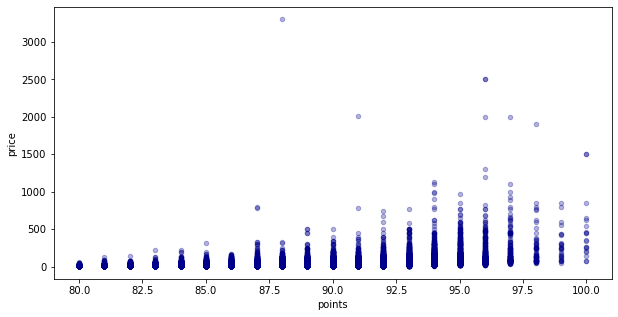

In [3]:
import matplotlib.pyplot as plt

table.plot.scatter(x='points', y='price', figsize=(10, 5), color='darkblue', alpha=0.3)

plt.show()

**Вопрос:** В чём суть метода наименьших квадратов? 

Выпишите формулы для вычисления параметров $a$ и $b$, 

а затем напишим класс `MLS2d`, который нужно отнаследовать от [sklearn.base.RegressorMixin](https://scikit-learn.org/stable/modules/generated/sklearn.base.RegressorMixin.html):

In [4]:
from sklearn.base import RegressorMixin

class MLS2d(RegressorMixin):
    def fit(self, X, Y):
        N = len(X)
    
        sum_X = X.sum()
        sum_Y = Y.sum()
    
        self.b = N * (X * Y).sum() - sum_X * sum_Y
        self.b /= N * (X ** 2).sum() - sum_X ** 2
    
        self.a = sum_Y - self.b * sum_X
        self.a /= N
        
        return self
    
    def predict(self, X):
        return self.a + self.b * X

In [5]:
model_2d = MLS2d().fit(X_train['points'], Y_train)

print(f'a = {model_2d.a}')
print(f'b = {model_2d.b}')

a = -466.812668581132
b = 5.675216795743072


Вычислим среднию квадратическую ошибку:

In [6]:
Y_pred = model_2d.predict(X_test['points'])

MSE = lambda Y, Y_pred: ((Y - Y_pred) ** 2).sum() / len(Y)

print(f'MSE: {MSE(Y_test, Y_pred)}')

MSE: 1125.6275430492763


Постройте получившеюся прямую поверх предыдущего графика зависимости цены от оценки:

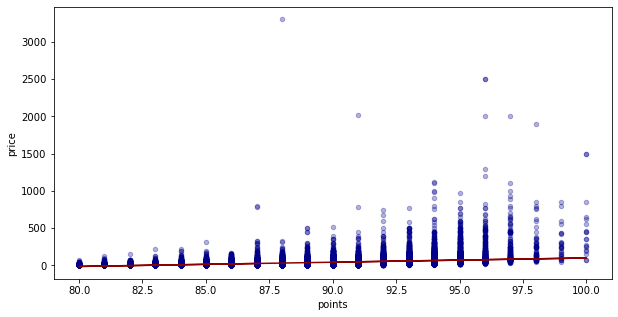

In [7]:
table.plot.scatter(x='points', y='price', figsize=(10, 5), color='darkblue', alpha=0.3)

plt.plot(X['points'], model_2d.predict(X['points']), color='darkred')
plt.show()

## Многомерный случай

Мы можем использовать не только оценку экспертов для предсказания цены, но и, например, страну производителя.

Для этого нам нужно закодировать подобные признаки - будем использовать [sklearn.preprocessing.OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html). 

Напишим класс, который бы наследовался от класса OneHotEncoder, но работал бы c таблицами и в качестве аргумента принемал также список колонок, которые требуется закодировать:

In [8]:
import numpy as np

from sklearn.preprocessing import OneHotEncoder

class PDEncoder(OneHotEncoder):
    def __init__(self, columns=None, **kwargs):
        super(PDEncoder, self).__init__(**kwargs)
        
        self.columns = columns
        
    def preprocessing(self, X):
        if self.columns:
            X = X[self.columns]
        
        return X
    
    def fit(self, X):
        OneHotEncoder.fit(self, self.preprocessing(X))
        return self
    
    def transform(self, X):
        X_preproc = self.preprocessing(X)
        vectors = OneHotEncoder.transform(self, X_preproc).toarray()
        
        categories = np.concatenate(self.categories_)
        X_preproc = pd.DataFrame(vectors, columns=categories, index=X_preproc.index)
        
        X = X.loc[X_preproc.index].drop(columns=self.columns).join(X_preproc)
        
        return X

In [9]:
encoder = PDEncoder(columns=['country'])

X_train_ = encoder.fit_transform(X_train[['points', 'country']])
X_test_ = encoder.transform(X_test[['points', 'country']])

X_test_.head(3)

,points,Argentina,Australia,Austria,Brazil,Bulgaria,Canada,Chile,England,France,...,Mexico,Moldova,Morocco,New Zealand,Portugal,Romania,South Africa,Spain,US,Uruguay
55315,84,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40656,92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77459,89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Выпишите формулы для многомерного случая, воспользовавшись матречным дифференцированием, 

а затем напишим, соответсвующий класс:

In [10]:
class MLS(RegressorMixin):
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
    
    @staticmethod
    def _add_intercept(X):
        I = np.ones(len(X))[:, np.newaxis]
        X = np.hstack([I, X])
        
        return X
        
    def fit(self, X, Y):
        if self.fit_intercept:
            X = MLS._add_intercept(X)
        
        X_T = X.transpose()
        A = X_T.dot(X)
        
        E, _ = np.linalg.eigh(A)
        self.condition_number = E[-1] / E[0]
        
        self.W = X_T.dot(Y)
        self.W = np.linalg.inv(A).dot(self.W)
        
        return self
    
    def predict(self, X):
        if self.fit_intercept:
            X = MLS._add_intercept(X)
        
        return X.dot(self.W)

In [11]:
model = MLS().fit(X_train[['points']], Y_train)

assert (model.W - np.array([model_2d.a, model_2d.b])).sum() < 10 ** -6

In [12]:
model = MLS().fit(X_train_, Y_train)

Вычислим среднию квадратическую ошибку:

In [13]:
Y_pred = model.predict(X_test_)

print(f'MSE: {MSE(Y_test, Y_pred)}')

MSE: 2315.472146567045


**Вопрос:** Удалось ли повысить качество предсказания?

Построим модель без свободной переменной:

In [14]:
model = MLS(fit_intercept=False).fit(X_train_, Y_train)
Y_pred = model.predict(X_test_)

print(f'MSE: {MSE(Y_test, Y_pred)}')

MSE: 1103.2469334198452


Обучите [sklearn.linear_model.LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) и убедитесь в том, что получили сравнимое значение `MSE`:

In [15]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X_train_, Y_train)

Y_pred = model.predict(X_test_)

print(f'MSE: {MSE(Y_test, Y_pred)}')

MSE: 1103.246933419843


**Вопрос:** Удалось ли теперь повысить качество предсказания? В чём была проблема?

In [16]:
model = MLS().fit(X_train_, Y_train)

print('LR with intercept')
print(f'Condition number: {model.condition_number}')

LR with intercept
Condition number: 2.018538891668345e+17


In [17]:
model = MLS(fit_intercept=False).fit(X_train_, Y_train)

print('LR without intercept')
print(f'Condition number: {model.condition_number}')

LR without intercept
Condition number: 197982359.92191002


Расширим ещё признаковое описание, добавив сорт винограда:

In [18]:
encoder = PDEncoder(columns=['country', 'variety'])

X_train_ = encoder.fit_transform(X_train[['points', 'country', 'variety']])
X_test_ = encoder.transform(X_test[['points', 'country', 'variety']])

model = MLS(fit_intercept=False).fit(X_train_, Y_train)

Y_pred = model.predict(X_test_)

print(f'MSE: {MSE(Y_test, Y_pred)}')
print(f'Condition number: {model.condition_number}')

MSE: 58315.964960996505
Condition number: -9.482188024869054e+22


**Вопрос**: Удалось ли теперь повысить качество предсказания? В чём может быть проблема?

## Ридж-регрессия

In [19]:
class RR(MLS):
    def __init__(self, alpha=0.01, **kwargs):
        super(RR, self).__init__(**kwargs)
        
        self.alpha = alpha
        
    def fit(self, X, Y):
        if self.fit_intercept:
            X = MLS._add_intercept(X)
        
        X_T = X.transpose()
        
        A = X_T.dot(X)
        A += self.alpha * np.eye(A.shape[0])
        
        E, _ = np.linalg.eigh(A)
        self.condition_number = E[-1] / E[0]
        
        self.W = X_T.dot(Y)
        self.W = np.linalg.inv(A).dot(self.W)
        
        return self

In [20]:
model = RR(alpha=0.01, fit_intercept=False).fit(X_train_, Y_train)

Y_pred = model.predict(X_test_)

print(f'MSE: {MSE(Y_test, Y_pred)}')
print(f'Condition number: {model.condition_number}')

MSE: 1033.6997076072437
Condition number: 43155673268.98437


In [21]:
model = RR(alpha=0.01).fit(X_train_, Y_train)

Y_pred = model.predict(X_test_)

print(f'MSE: {MSE(Y_test, Y_pred)}')
print(f'Condition number: {model.condition_number}')

MSE: 1033.6948976913304
Condition number: 43161146038.43176


In [22]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=0.01).fit(X_train_, Y_train)

Y_pred = model.predict(X_test_)

print(f'MSE: {MSE(Y_test, Y_pred)}')

MSE: 1033.6948406862173


In [23]:
from time import time

encoder = PDEncoder(columns=['country', 'variety', 'winery'])

X_train_ = encoder.fit_transform(X_train[['points', 'country', 'variety', 'winery']])
X_test_ = encoder.transform(X_test[['points', 'country', 'variety', 'winery']])

begin_time = time()

model = RR(alpha=0.01, fit_intercept=False).fit(X_train_, Y_train)

print(f'Time: {time() - begin_time} ({X_train_.shape[1]} features )')

Y_pred = model.predict(X_test_)

print(f'MSE: {MSE(Y_test, Y_pred)}')
print(f'Condition number: {model.condition_number}')

Time: 15.239123821258545 (3696 features )
MSE: 787.45982878944
Condition number: 43155675919.55444


## SGD

Обучите [sklearn.linear_model.SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) предсказывать значение цены по оценке с качеством не хуже, чем у `MLS`. 

Для этого вам нужно проделать ряд эксперементов и подобрать наилучшую стратегию обучения, используя [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

Визуализируйте ваши эксперементы.